In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm_notebook as tqdm
import cv2
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
import os
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from datetime import datetime
import scipy.io
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torchvision.models as models
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!nvidia-smi

Sat Jun  6 13:26:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
my_transform = {
                'test': transforms.Compose([
                        transforms.Resize((224, 224)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                        ])
                }

In [0]:
path_to_dataset = "/content/drive/My Drive/FINAL_Project/test_dataset"
test_dataset = torchvision.datasets.ImageFolder(path_to_dataset, transform = my_transform['test'])

In [6]:
len(test_dataset)

1359

In [0]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

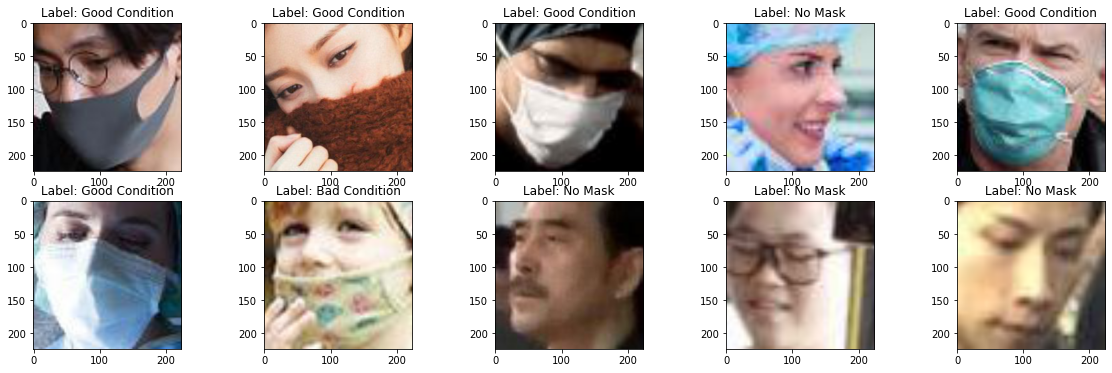

In [8]:
labels_dict = {0: 'Good Condition', 1: 'No Mask', 2: 'Bad Condition'}
scaler = UnNormalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
inds = np.random.choice(len(test_dataset), 10, replace = False)
fig, axs = plt.subplots(2, 5, figsize = (20,6))
ax = axs.flatten()
for i, j in enumerate(inds):
  ax[i].imshow(scaler(test_dataset[j][0]).transpose(0,1).transpose(1,2))
  ax[i].set_title('Label: ' + labels_dict[test_dataset[j][1]])

In [14]:
def get_class_distribution(dataset_obj):
    count_dict = {v:0 for k,v in dataset_obj.class_to_idx.items()}
    for element in dataset_obj:
        y_lbl = element[1]
        count_dict[y_lbl] += 1     
    return count_dict

print("Distribution of classes: \n", get_class_distribution(test_dataset))

Distribution of classes: 
 {0: 584, 1: 569, 2: 206}


In [0]:
test_batch_gen = torch.utils.data.DataLoader(test_dataset, batch_size=1, num_workers=4, pin_memory=True)

In [0]:
#@title Models
class ConvBlock(nn.Module):
  def __init__(self, in_channels, hidden_channels, kernel_size = 3, padding = 1, stride = 1):
    super(ConvBlock, self).__init__()
    self.block = nn.Sequential(nn.Conv2d(in_channels, hidden_channels, kernel_size=kernel_size, padding= padding, stride=stride),
                                nn.ReLU(),
                               nn.MaxPool2d(2))
  def __call__(self, x):
    return self.block(x)
class MaskDetectionModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels = 3):
        super(MaskDetectionModel, self).__init__()
        self.block1 = ConvBlock(in_channels, hidden_channels)
        self.block2 = ConvBlock(hidden_channels, hidden_channels*2)
        self.block3 = ConvBlock(hidden_channels*2, hidden_channels*4)
        self.block4 = nn.Sequential(nn.Linear( hidden_channels*4* 28*28, 1024),
                                    nn.BatchNorm1d(1024),
                                    nn.ReLU(),
                                    nn.Linear(1024, out_channels), 
                                    nn.LogSoftmax(dim = 1))
        
        # Initialize layers' weights
        for sequential in [self.block1, self.block2, self.block3, self.block4]:
            for layer in sequential.children():
                if isinstance(layer, (nn.Linear, nn.Conv2d)):
                    nn.init.xavier_uniform_(layer.weight)
    
    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = out.view(out.size(0), -1)
        out = self.block4(out)
        return torch.exp(out)
        
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


def make_model():
    model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        Flatten(),
        nn.Dropout(),
        nn.Linear(512 * 14 ** 2, 3),
        nn.BatchNorm1d(3),
        nn.ReLU(),
        nn.Linear(3, 3)
        # nn.Softmax(dim=1)
    )
    return model

In [0]:
model_names = [ 'Resnet18_tuning_classifier_MAFA' ,'Resnet18_tuning_all_MAFA', 'Custom_model_1', 'vgg11_bn', 'Resnet50_on_mask_set', 'Custom_model_2']

In [0]:
def create_instance(model_name, path = None, device='cuda'):
  best_model_path = path + model_name + '.best.pth'
  if (model_name=='Resnet18_tuning_all_MAFA') or (model_name == 'Resnet18_tuning_classifier_MAFA'):
    model = models.resnet18(pretrained=True)
    for layer, param in model.named_parameters():
      param.requires_grad = False
    model.fc = torch.nn.Sequential(nn.Linear(512, 32),
                                    nn.ReLU(),
                                    nn.Linear(32, 3),
                                    nn.Softmax(dim=1))
    model.load_state_dict(torch.load(best_model_path))

  elif model_name == 'vgg11_bn':
    model = models.vgg11_bn(pretrained=True)
    model.classifier = torch.load(best_model_path)

  elif model_name == 'Custom_model_1':
    model = torch.load(best_model_path)['model']
    model.eval()

  elif model_name == 'Resnet50_on_mask_set':
    model = models.resnet50(pretrained=True)
    for layer, param in model.named_parameters():
      param.requires_grad = True
    model.fc = torch.nn.Sequential(nn.Linear(2048, 32),
                                   #nn.BatchNorm1d(32),
                                    nn.ReLU(),
                                    nn.Linear(32, 3),
                                    nn.Softmax(dim=1))
    model.load_state_dict(torch.load(best_model_path))
  elif model_name == 'Custom_model_2':
    model = MaskDetectionModel(3, 64)
    model.load_state_dict(torch.load(best_model_path))
  
  model.eval()
  model.to(device)
  return model

In [0]:
def test_model(model, iterator, device='cuda'):
    target = []
    preds = []
    model.eval();
    with torch.no_grad():
      for X, y in tqdm(test_batch_gen):
        out_first = model(X.to(device))
        label = out_first.argmax(dim=1)
        target.append(y.item())
        preds.append(label.item())
    acc = accuracy_score(np.array(target), np.array(preds))
    cm = confusion_matrix(np.array(target), np.array(preds), normalize='true')
    return acc, cm

In [35]:
dict_with_results = {}
dict_with_models = {}
for i, name in enumerate(model_names):
  if i<4:
    model = create_instance(name,'drive/My Drive/FINAL_Project/Mafa/', device='cuda')
  else:
    model = create_instance(name,'drive/My Drive/FINAL_Project/Mask_set/', device='cuda')
  
  acc, cm = test_model(model, test_batch_gen, device='cuda')
  dict_with_results[name] = {'accuracy': acc, 'confusion_matrix': cm}
  dict_with_models[name] = model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


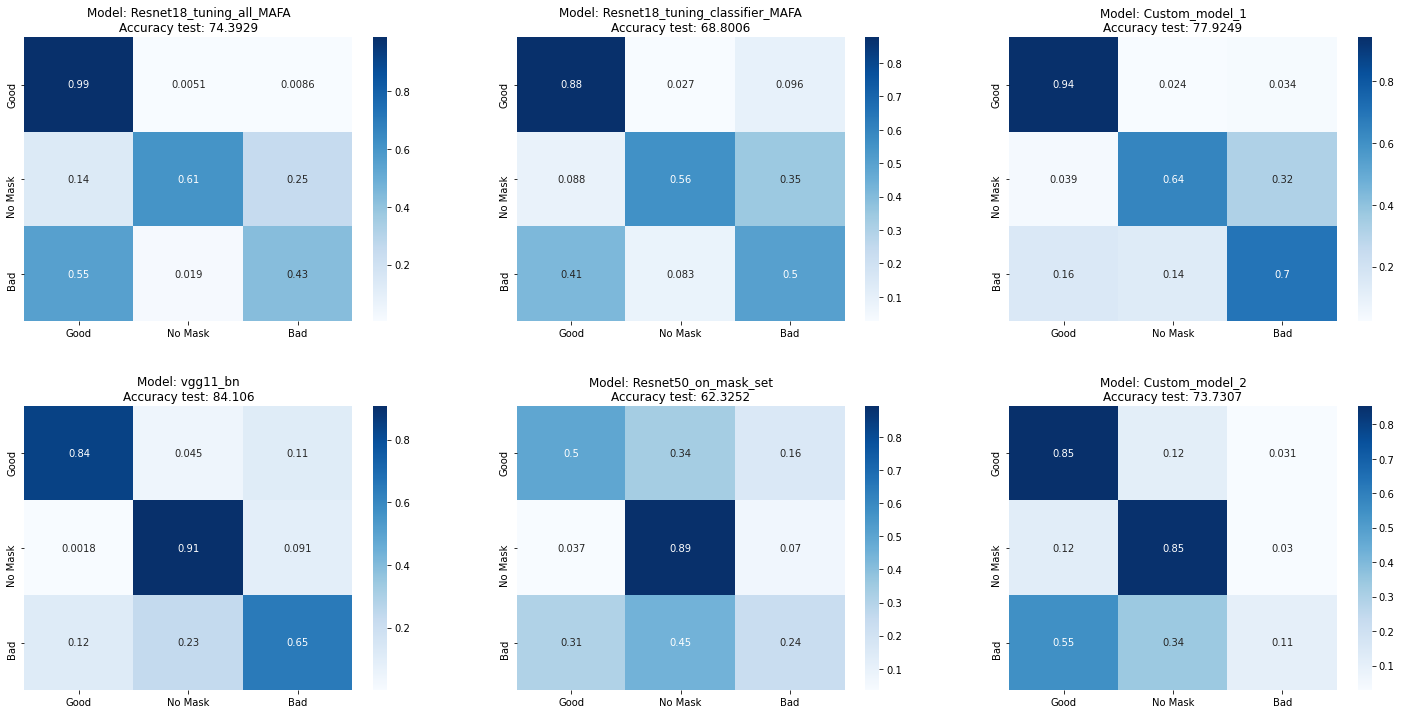

In [57]:
labels_dict = {0: 'Good', 1: 'No Mask', 2: 'Bad'}
fig, axs  = plt.subplots(2, 3, figsize = (25, 12))
ax = axs.flatten()
for i, name in enumerate(list(dict_with_results.keys())):
  acc, cm = dict_with_results[name]['accuracy'], dict_with_results[name]['confusion_matrix'] 
  df_cm = pd.DataFrame(cm, index = labels_dict.values(), columns = labels_dict.values())
  sns.heatmap(df_cm, annot=True, ax = ax[i], cmap = 'Blues')
  ax[i].set_title('Model: ' + name + '\n' + 'Accuracy test: ' + np.round(acc*100, 4).astype(str))
fig.subplots_adjust(wspace=0.2, hspace = 0.3)
fig.savefig('Confusion_matrix.png', dpi = 300, bbox_inches = 'tight')

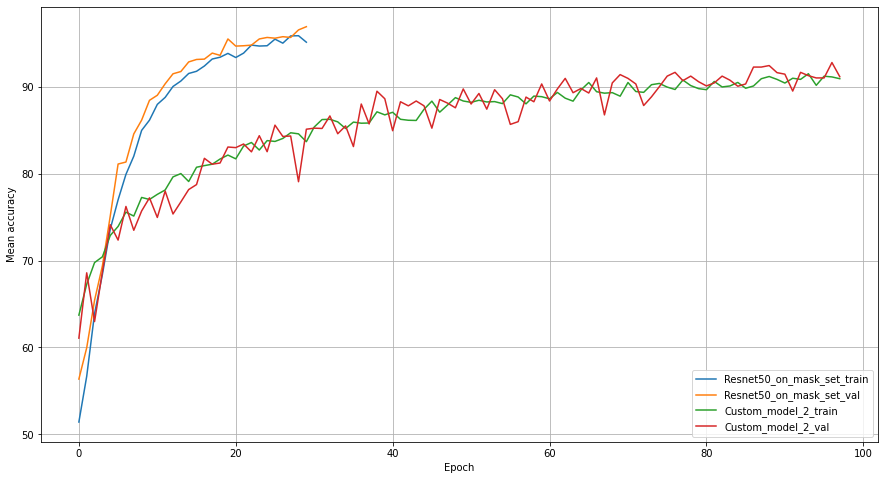

In [65]:
import pickle
plt.figure(figsize = (15, 8))
for name in ['Resnet50_on_mask_set', 'Custom_model_2']:
  data  = pickle.load(open(f'drive/My Drive/FINAL_Project/Mask_set/{name}.pkl', 'rb'))
  plt.plot(data[0], label = name + '_train')
  plt.plot(data[1], label = name + '_val')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Mean accuracy')
plt.savefig('Accuracy_mask_set.png', dpi = 300, bbox_inches = 'tight')